In [129]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import json

from tqdm import tqdm

from src.utils import calculate_results_row, plot_performance_frs, plot_histogram, plot_frs_histogram, plot_compensation_barplot

# make the default font size point 7
plt.rcParams.update({"font.size": 7})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load datasets

First let's load the predicted effects for those in *rpoB* (which is the only gene in the WHOv2 catalogue that confers resistance to RIF). This will let us identify all the definite resistance-associated variants. (If we used the WHOv2 catalogue we'd have to unpack and deal with generic rules which is harder).

In [63]:
effects = pd.read_csv('data/RIF_EFFECTS.csv.gz')

resistance_mutations = effects.GENE_MUTATION.unique()

print(f"There are {len(resistance_mutations)} unique resistance mutations according to WHOv2 in our dataset")

print(f"These include {resistance_mutations[:3]}")

There are 127 unique resistance mutations according to WHOv2 in our dataset
These include ['rpoB_S450L' 'rpoB_V170F' 'rpoB_H445Y']


We will get our list of compensatory mutations from this paper

> Brunner V, Fowler PW
>
> Compensatory mutations are associated with increased in vitro growth in resistant clinical samples of *Mycobacterium tuberculosis*.
>
> mGen 10:001187 doi:10.1099/mgen.0.001187

The list is publicly available from here:

https://github.com/fowler-lab/tb-rnap-compensation

In [64]:
CMs = pd.read_csv('data/final_CM_hit_list.csv')
CMs = CMs[CMs.homoplasy == True]
compensatory_mutations = CMs['putative CM'].unique()

print(f"There are {len(compensatory_mutations)} compensatory mutations in the RNAP identified by this study")
print(f"These include {compensatory_mutations[:3]}")

There are 51 compensatory mutations in the RNAP identified by this study
These include ['rpoC_V483G' 'rpoC_I491V' 'rpoC_V483A']


### Drug susceptibility measurements

Let's load in these; one problem we will have to solve is that some samples have more than one rifampicin measurement. For example, they could have an MIC from a UKMYC6 96-well broth microdilution plate but they could also have an R/S from a MGIT960 tube. The approach we will take is to classify any samples as resistant if any of their DST results indicate resistance and we will keep, by preference, the UKMYC measurements since we have more detailed information on these.

In [65]:
phenotypes = pd.read_csv('data/RIF_PHENOTYPES.csv.gz')

agg_phenotypes = phenotypes[['UNIQUEID', 'DRUG']].groupby(['UNIQUEID']).count()
agg_phenotypes.value_counts(dropna=False)

multiples = agg_phenotypes[agg_phenotypes.DRUG>1].index
singles = agg_phenotypes[agg_phenotypes.DRUG==1].index

print(f"There are {len(singles) + len(multiples)} samples with at least one RIF DST measurement.")
print(f"Of these {len(singles)} samples have a single DST measurement and {len(multiples)} have multiple DST measurements.")

phenotypes.set_index('UNIQUEID', inplace = True)
phenotypes[:3]

There are 52148 samples with at least one RIF DST measurement.
Of these 43150 samples have a single DST measurement and 8998 have multiple DST measurements.


,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE,QUALITY
UNIQUEID,,,,,,,,,
site.24.subj.PT-2.lab.1997-606.iso.1,RIF,SEQTREAT2020,liquid media,MGIT,BACTEC460,1.0,NaN,S,MEDIUM
site.24.subj.PT-4.lab.1998-151.iso.1,RIF,SEQTREAT2020,liquid media,MGIT,BACTEC460,1.0,NaN,S,MEDIUM
site.24.subj.PT-5.lab.1998-713.iso.1,RIF,SEQTREAT2020,liquid media,MGIT,BACTEC460,1.0,NaN,S,MEDIUM


In [66]:
# go through the list of UNIQUEIDs with multiple RIF DST measurements and apply the logic described above

table = []
for uid in tqdm(multiples):

    phenotype=None
    first_row=True
    for idx,row in phenotypes.loc[uid].iterrows():

        # if this is the first entry, just add it
        if first_row:

            table.append(row)
            phenotype=row.PHENOTYPE
            method=row.METHOD_3
            first_row=False

        else:   

            # but if the new phenotype is resistant, add the row
            if phenotype=='S' and row.PHENOTYPE == 'R':
                table[-1] = row

            # or replace with the UKMYC result if the phenotypes are the same 
            elif phenotype==row.PHENOTYPE and row.METHOD_3 in ['UKMYC5', 'UKMYC6']:
                table[-1] = row

phenotypes = pd.concat([phenotypes.loc[singles], pd.DataFrame(table)])
assert phenotypes.index.duplicated().sum()==0, 'there are still duplicates in the table'
phenotypes.index.name = 'UNIQUEID'
phenotypes = phenotypes[phenotypes.PHENOTYPE.isin(['S', 'R'])]
print(f"We have {len(phenotypes)} samples with a definite (R/S) DST measurement for RIF")

phenotypes = phenotypes[phenotypes.QUALITY!='LOW']
print(f"Removing samples where there is disagreement about the phenotype leaves {len(phenotypes)} samples")

phenotypes[:3]

100%|██████████| 8998/8998 [00:03<00:00, 2309.76it/s]


We have 51183 samples with a definite (R/S) DST measurement for RIF
Removing samples where there is disagreement about the phenotype leaves 48031 samples


,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE,QUALITY
UNIQUEID,,,,,,,,,
site.00.subj.1000347.lab.H111540004.iso.1,RIF,NEJM2018,solid media,LJ,resistance ratio,NaN,NaN,R,MEDIUM
site.00.subj.1000595.lab.H123460044.iso.1,RIF,NEJM2018,solid media,LJ,resistance ratio,NaN,NaN,R,MEDIUM
site.00.subj.1004213.lab.H111060034.iso.1,RIF,NEJM2018,solid media,LJ,resistance ratio,NaN,NaN,R,MEDIUM


### Genetics

Since not all samples with DST measurements have also been whole-genome sequenced, and of those, not all have mutations in the RNA polymerase we have to (i) identify those samples with WGS data and then (ii) consider those samples with mutations in the RNAP.


In [67]:
genomes = pd.read_csv('data/GENOMES.csv.gz')
genomes.set_index('UNIQUEID', inplace = True)
genomes['HAS_GENOME'] = True
phenotypes['HAS_DST'] = True
samples = genomes[['HAS_GENOME']].join(phenotypes[['HAS_DST','PHENOTYPE']], how='left')
samples.HAS_DST = samples.HAS_DST.fillna(False)
print(f"We have {len(samples)} samples a genome and {(samples.HAS_DST).sum()} also have a definite DST measurement for RIF")
samples[:3]

We have 44405 samples a genome and 30459 also have a definite DST measurement for RIF


/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_23307/214567041.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  samples.HAS_DST = samples.HAS_DST.fillna(False)


,HAS_GENOME,HAS_DST,PHENOTYPE
UNIQUEID,,,
site.01.subj.DR0682.lab.DR0682.iso.1,True,True,R
site.01.subj.DR0674.lab.DR0674.iso.1,True,False,NaN
site.01.subj.DR0134.lab.DR0134.iso.1,True,True,R


Now load all the mutations in the RNA polymerase and identify which mutations are associated with resistance and which have been identified as compensatory

In [68]:
mutations = pd.read_csv('data/RNAP_MUTATIONS.csv.gz')

# add resistance and compensatory mutation flags to mutations table: 
#  need to check for minor allele before concatenating GENE_MUTATION 
mutations['GENE_MUTATION'] = np.where(
    mutations['IS_MINOR_ALLELE'],  # Condition: if IS_MINOR_ALLELE is True
    mutations['GENE'].astype(str) + '_' + mutations['MINOR_MUTATION'].astype(str),  # Then: use GENE + MINOR_MUTATION
    mutations['GENE'].astype(str) + '_' + mutations['MUTATION'].astype(str)  # Else: use GENE + MUTATION
)

# all the homogenous mutations have an FRS of NaN so set to unity
mutations.loc[~mutations.IS_MINOR_ALLELE, 'FRS'] = 1

mutations['IS_RESISTANT_MUTATION'] = mutations['GENE_MUTATION'].isin(resistance_mutations)
mutations['IS_COMPENSATORY_MUTATION'] = mutations['GENE_MUTATION'].isin(compensatory_mutations)
mutations.set_index('UNIQUEID', inplace=True)

print(f"There are {len(mutations)} RNAP mutations in {len(mutations.index.unique())} samples that have been whole genome sequenced in our dataset")
mutations[:3]

There are 176555 RNAP mutations in 38787 samples that have been whole genome sequenced in our dataset


,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,IS_RESISTANT_MUTATION,IS_COMPENSATORY_MUTATION
UNIQUEID,,,,,,,,,,,,,,,,,,,
site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,1.0,rpoB_S450L,True,False
site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,False,NaN,1.0,rpoB_A1075A,False,False
site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,1.0,rpoB_S450L,True,False


In [69]:
# aggregate mutations by UNIQUEID and keep columns of interest: define FRS to be the maximum of any resistant mutations, otherwise the maximum of the remaining mutations

def aggregate_minor_major_allele(group):

    resistant_frs_value = None
    compensatory_frs_value = None

    # Check if any row has both IS_MINOR_ALLELE and RESISTANT_MUTATION    
    resistant_minor_allele_flag = any((group['IS_MINOR_ALLELE']) & (group['IS_RESISTANT_MUTATION']))

    # Check if any row both isn't IS_MINOR_ALLELE and RESISTANT_MUTATION
    resistant_major_allele_flag = any((~group['IS_MINOR_ALLELE']) & (group['IS_RESISTANT_MUTATION']))

    # Get the rows where there is a resistant major allele
    resistant_major_allele_rows = group[(~group['IS_MINOR_ALLELE']) & (group['IS_RESISTANT_MUTATION'])]

    # Get the rows where there is a resistant minor allele
    resistant_minor_allele_rows = group[(group['IS_MINOR_ALLELE']) & (group['IS_RESISTANT_MUTATION'])]
    
    if resistant_major_allele_rows.empty:

        if not resistant_minor_allele_rows.empty:

            # If there are resistant minor alleles, get the maximum FRS value for those rows
            resistant_frs_value = resistant_minor_allele_rows['FRS'].max()

    else:

        resistant_frs_value = resistant_major_allele_rows['FRS'].max()

    # Check if any row has both IS_MINOR_ALLELE and COMPENSATORY_MUTATION    
    compensatory_minor_allele_flag = any((group['IS_MINOR_ALLELE']) & (group['IS_COMPENSATORY_MUTATION']))

    # Check if any row both isn't IS_MINOR_ALLELE and COMPENSATORY_MUTATION
    compensatory_major_allele_flag = any((~group['IS_MINOR_ALLELE']) & (group['IS_COMPENSATORY_MUTATION']))

    # Get the rows where there is a resistant major allele
    compensatory_major_allele_rows = group[(~group['IS_MINOR_ALLELE']) & (group['IS_COMPENSATORY_MUTATION'])]

    # Get the rows where there is a resistant minor allele
    compensatory_minor_allele_rows = group[(group['IS_MINOR_ALLELE']) & (group['IS_COMPENSATORY_MUTATION'])]
    
    if compensatory_major_allele_rows.empty:

        if not compensatory_minor_allele_rows.empty:

            # If there are resistant minor alleles, get the maximum FRS value for those rows
            compensatory_frs_value = compensatory_minor_allele_rows['FRS'].max()

    else:

        compensatory_frs_value = compensatory_major_allele_rows['FRS'].max()

    return pd.Series({
        'HAS_RNAP_MUTATIONS': True,
        'HAS_RESISTANT_MUTATION': group['IS_RESISTANT_MUTATION'].max(),
        'N_RAV': group['IS_RESISTANT_MUTATION'].sum(),
        'HAS_MINOR_RAV': resistant_minor_allele_flag,
        'HAS_MAJOR_RAV': resistant_major_allele_flag,
        'MAX_RAV_FRS': resistant_frs_value,  # Use the maximum FRS for any RAVs present
        'HAS_COMPENSATORY_MUTATION': group['IS_COMPENSATORY_MUTATION'].max(),
        'N_CM': group['IS_COMPENSATORY_MUTATION'].sum(),
        'HAS_MINOR_CM': compensatory_minor_allele_flag,
        'HAS_MAJOR_CM': compensatory_major_allele_flag,
        'MAX_CM_FRS': compensatory_frs_value,  # Use the maximum FRS for any compensatory mutations present
    })

# Apply the custom aggregation function
agg_mutations = mutations.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()
agg_mutations.set_index('UNIQUEID', inplace=True)
agg_mutations[:3]

,HAS_RNAP_MUTATIONS,HAS_RESISTANT_MUTATION,N_RAV,HAS_MINOR_RAV,HAS_MAJOR_RAV,MAX_RAV_FRS,HAS_COMPENSATORY_MUTATION,N_CM,HAS_MINOR_CM,HAS_MAJOR_CM,MAX_CM_FRS
UNIQUEID,,,,,,,,,,,
site.00.subj.1000347.lab.H111540004.iso.1,True,True,1,False,True,1.0,False,0,False,False,NaN
site.00.subj.1000595.lab.H123460044.iso.1,True,True,1,False,True,1.0,True,1,False,True,1.0
site.00.subj.1004213.lab.H111060034.iso.1,True,True,1,False,True,1.0,True,1,False,True,1.0


Now we can join the information on the samples which have RNAP mutations to the table of samples with a DST result and a whole genome. We will need to fill in the gaps for those samples which do not have any RNAP mutations.

In [70]:
samples = samples.join(agg_mutations, how='left')

samples['IS_RESISTANT'] = samples.PHENOTYPE == 'R'

# because we did a left join and hence there were a lot of NaNs to fill in, we need to force these columns to be boolean
for i in ['HAS_RNAP_MUTATIONS', 'HAS_RESISTANT_MUTATION', 'HAS_MINOR_RAV', 'HAS_MAJOR_RAV', 'HAS_COMPENSATORY_MUTATION', 'HAS_MINOR_CM', 'HAS_MAJOR_CM']:
    samples[i] = samples[i].fillna(False)    
    samples[i] = samples[i].astype(bool)

samples[:3]

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_23307/2861957674.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  samples[i] = samples[i].fillna(False)
/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_23307/2861957674.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  samples[i] = samples[i].fillna(False)
/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_23307/2861957674.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_obj

,HAS_GENOME,HAS_DST,PHENOTYPE,HAS_RNAP_MUTATIONS,HAS_RESISTANT_MUTATION,N_RAV,HAS_MINOR_RAV,HAS_MAJOR_RAV,MAX_RAV_FRS,HAS_COMPENSATORY_MUTATION,N_CM,HAS_MINOR_CM,HAS_MAJOR_CM,MAX_CM_FRS,IS_RESISTANT
UNIQUEID,,,,,,,,,,,,,,,
site.01.subj.DR0682.lab.DR0682.iso.1,True,True,R,True,True,1.0,False,True,1.0,False,0.0,False,False,NaN,True
site.01.subj.DR0674.lab.DR0674.iso.1,True,False,NaN,True,True,1.0,False,True,1.0,False,0.0,False,False,NaN,False
site.01.subj.DR0134.lab.DR0134.iso.1,True,True,R,True,True,1.0,False,True,1.0,True,1.0,False,True,1.0,True


In [71]:
print(f"We have {len(samples)} samples with genetics and {(samples.HAS_DST).sum()} samples that also have a definite DST measurement for RIF\n")

print(f"Of the samples with just genetics, {((samples.HAS_RNAP_MUTATIONS) & (samples.HAS_DST)).sum()} have one or more mutations in the RNAP\n")

print(f"As you might expect nearly all of the samples with no RNAP mutations test as susceptible to RIF:")

samples_with_dst = copy.deepcopy(samples[(samples.HAS_DST) & (samples.HAS_GENOME)])
print(pd.crosstab(samples_with_dst.HAS_RNAP_MUTATIONS, samples_with_dst.IS_RESISTANT))


We have 44405 samples with genetics and 30459 samples that also have a definite DST measurement for RIF

Of the samples with just genetics, 27367 have one or more mutations in the RNAP

As you might expect nearly all of the samples with no RNAP mutations test as susceptible to RIF:
IS_RESISTANT        False  True 
HAS_RNAP_MUTATIONS              
False                3031     61
True                17344  10023


In [72]:
print(f"There are {samples_with_dst.HAS_RESISTANT_MUTATION.sum()} samples with a RIF resistance-conferring mutation in the RNAP and RIF DST, at any level of read support")

print(f"Of these {(samples_with_dst.HAS_MAJOR_RAV & ~samples_with_dst.HAS_MINOR_RAV).sum()} samples only have ≥1 homogeneous RAVs whilst {(~samples_with_dst.HAS_MAJOR_RAV & samples_with_dst.HAS_MINOR_RAV).sum()} have ≥1 minor RAVs and {(samples_with_dst.HAS_MAJOR_RAV & samples_with_dst.HAS_MINOR_RAV).sum()} have ≥1 of both")

There are 10249 samples with a RIF resistance-conferring mutation in the RNAP and RIF DST, at any level of read support
Of these 9967 samples only have ≥1 homogeneous RAVs whilst 263 have ≥1 minor RAVs and 19 have ≥1 of both


Here minor RAV means any variant with less than 90% read support; so what is the distribution? Do they all have just a bit less than 90%?

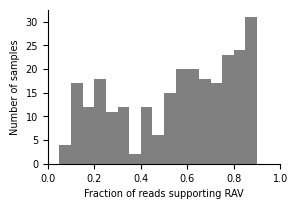

In [73]:
df = samples_with_dst[(~samples_with_dst.HAS_MAJOR_RAV) & (samples_with_dst.HAS_MINOR_RAV) & (samples_with_dst.MAX_RAV_FRS<1) & (samples_with_dst.MAX_RAV_FRS>0.05)]
plot_frs_histogram(df, savefig=True)

Let's therefore change the definition of what is a resistance associated variant by altering the FRS which leads to it being classified and therefore predicting resistance.

We will store the results in a `pandas.DataFrame` so we can later plot graphs etc.

In [74]:
for i in range(5, 100, 5):
    cutoff = i / 100
    df = samples_with_dst.copy() 
    df['HAS_RESISTANT_MUTATION'] = ((df['MAX_RAV_FRS'] >= cutoff) & (df.HAS_MINOR_RAV)) | (df.HAS_MAJOR_RAV)
    a = calculate_results_row(df, description='scan FRS', min_FRS=cutoff)
    if i == 5:
        results_table = pd.DataFrame(a).T
    else:
        results_table = pd.concat([results_table,pd.DataFrame(a).T])

results_table

,description,min_FRS,TP,FP,P,TN,FN,N,sensitivity,specificity,PPV,NPV
0,scan FRS,0.05,9739,510,10084,19865,345,20375,0.965787,0.974969,0.950239,0.982929
0,scan FRS,0.1,9737,508,10084,19867,347,20375,0.965589,0.975067,0.950415,0.982834
0,scan FRS,0.15,9725,505,10084,19870,359,20375,0.964399,0.975215,0.950635,0.982253
0,scan FRS,0.2,9714,502,10084,19873,370,20375,0.963308,0.975362,0.950861,0.981722
0,scan FRS,0.25,9703,495,10084,19880,381,20375,0.962217,0.975706,0.951461,0.981195
0,scan FRS,0.3,9694,494,10084,19881,390,20375,0.961325,0.975755,0.951512,0.980761
0,scan FRS,0.35,9686,489,10084,19886,398,20375,0.960532,0.976,0.951941,0.980379
0,scan FRS,0.4,9684,489,10084,19886,400,20375,0.960333,0.976,0.951932,0.980282
0,scan FRS,0.45,9673,488,10084,19887,411,20375,0.959242,0.976049,0.951973,0.979752
0,scan FRS,0.5,9668,487,10084,19888,416,20375,0.958747,0.976098,0.952043,0.979511


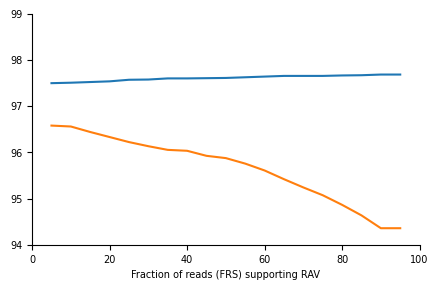

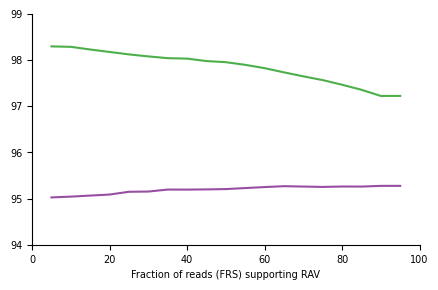

In [75]:
# plot the performance as we alter the minimum FRS

df = results_table.copy()
df = df[df.description=='scan FRS']

plot_performance_frs(df, save_figure=True, metrics=['sensitivity', 'specificity'], colours=["#ff7f0e", "#1f77b4"], save_name='fig-frs-sensitivity-specificity')
plot_performance_frs(df, save_figure=True, metrics=['PPV', 'NPV'], colours=['#984ea3', '#4daf4a'], save_name='fig-frs-ppv-npv')

Since sensitivity appears to rise let's compare two cases so we can do statistics

In [76]:
df = copy.deepcopy(samples_with_dst)
df['HAS_RESISTANT_MUTATION'] = ((df['MAX_RAV_FRS'] >= 0.05) & (df.HAS_MINOR_RAV)) | (df.HAS_MAJOR_RAV)
a = calculate_results_row(df, description='bar chart', min_FRS=0.05)
results_table = pd.concat([results_table,pd.DataFrame(a).T])

samples_major_only = samples_with_dst.copy()
samples_major_only['HAS_RESISTANT_MUTATION'] = samples_major_only['HAS_MAJOR_RAV']
b=calculate_results_row(samples_major_only, description='bar chart', min_FRS=0.90)
results_table = pd.concat([results_table,pd.DataFrame(b).T])

results_table = results_table.sort_values('min_FRS', ascending=False)
results_table


,description,min_FRS,TP,FP,P,TN,FN,N,sensitivity,specificity,PPV,NPV
0,scan FRS,0.95,9515,472,10084,19903,569,20375,0.943574,0.976834,0.952739,0.972206
0,bar chart,0.9,9515,471,10084,19904,569,20375,0.943574,0.976883,0.952834,0.972207
0,scan FRS,0.9,9515,472,10084,19903,569,20375,0.943574,0.976834,0.952739,0.972206
0,scan FRS,0.85,9543,475,10084,19900,541,20375,0.946351,0.976687,0.952585,0.973534
0,scan FRS,0.8,9566,476,10084,19899,518,20375,0.948631,0.976638,0.952599,0.974629
0,scan FRS,0.75,9587,478,10084,19897,497,20375,0.950714,0.97654,0.952509,0.97563
0,scan FRS,0.7,9604,478,10084,19897,480,20375,0.9524,0.97654,0.952589,0.976444
0,scan FRS,0.65,9622,478,10084,19897,462,20375,0.954185,0.97654,0.952673,0.977307
0,scan FRS,0.6,9641,481,10084,19894,443,20375,0.956069,0.976393,0.95248,0.978217
0,scan FRS,0.55,9656,484,10084,19891,428,20375,0.957557,0.976245,0.952268,0.978936


sensitivity -7.583083759809194 3.374368441146938e-14


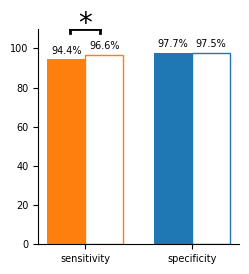

NPV -7.296398557265616 2.955725061567071e-13


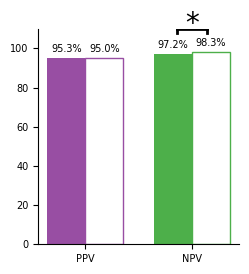

In [107]:
df = results_table[results_table.description=='bar chart']

plot_histogram(df, save_figure=True, metrics=['sensitivity', 'specificity'], colours=["#ff7f0e", "#1f77b4"], save_name='bar-sens-spec')
plot_histogram(df, save_figure=True, metrics=['PPV', 'NPV'], colours=['#984ea3', '#4daf4a'], save_name='bar-ppv-npv')

In [78]:
minor_samples = samples_with_dst[(~samples_with_dst.HAS_MAJOR_RAV) & (samples_with_dst.HAS_MINOR_RAV)].index
major_samples = samples_with_dst[(samples_with_dst.HAS_MAJOR_RAV) & (~samples_with_dst.HAS_MINOR_RAV)].index
both_samples = samples_with_dst[(samples_with_dst.HAS_MAJOR_RAV) & (samples_with_dst.HAS_MINOR_RAV)].index

In [79]:
mutations[mutations.index.isin(minor_samples) & (mutations.IS_RESISTANT_MUTATION)].GENE_MUTATION.value_counts()[:5]

GENE_MUTATION
rpoB_S450L    153
rpoB_D435V     33
rpoB_H445Y     32
rpoB_L430P     20
rpoB_L452P     18
Name: count, dtype: int64

In [80]:
mutations[mutations.index.isin(major_samples) & (mutations.IS_RESISTANT_MUTATION)].GENE_MUTATION.value_counts()[:5]

GENE_MUTATION
rpoB_S450L    6870
rpoB_D435V     837
rpoB_H445D     371
rpoB_H445Y     341
rpoB_D435Y     217
Name: count, dtype: int64

In [81]:
mutations[mutations.index.isin(both_samples) & (mutations.IS_RESISTANT_MUTATION)].GENE_MUTATION.value_counts()[:5]

GENE_MUTATION
rpoB_L430P    7
rpoB_S450L    5
rpoB_H445N    4
rpoB_D435E    3
rpoB_H445R    3
Name: count, dtype: int64

In [82]:
mutations[mutations.index.isin(both_samples) & (mutations.IS_RESISTANT_MUTATION)][['GENE_MUTATION','FRS']]

,GENE_MUTATION,FRS
UNIQUEID,,
site.08.subj.02TB2023.lab.21665.iso.1,rpoB_S450V,1.000
site.08.subj.02TB2023.lab.21665.iso.1,rpoB_D435E,0.765
site.08.subj.02TB2023.lab.21665.iso.1,rpoB_H445Q,0.333
site.04.subj.00091.lab.705647.iso.1,rpoB_L430P,1.000
site.04.subj.00091.lab.705647.iso.1,rpoB_S428R,0.609
site.04.subj.00546.lab.714945.iso.1,rpoB_S450L,1.000
site.04.subj.00546.lab.714945.iso.1,rpoB_L430P,0.120
site.03.subj.11408-15_LIB7169.lab.11408-15_LIB7169.iso.1,rpoB_D435V,1.000
site.03.subj.11408-15_LIB7169.lab.11408-15_LIB7169.iso.1,rpoB_S450G,1.000


## Compensatory mutations

Now let's describe the presence/distribution of compensatory mutations in the dataset

In [83]:
print(f"Of the {len(samples_with_dst)} samples with genetics and DST there are {samples_with_dst.HAS_COMPENSATORY_MUTATION.sum()} with at least one compensatory mutation at any level of read support")

print(f"Of these {(samples_with_dst.HAS_MAJOR_CM & ~samples_with_dst.HAS_MINOR_CM).sum()} samples only have ≥1 homogeneous CM whilst {(~samples_with_dst.HAS_MAJOR_CM & samples_with_dst.HAS_MINOR_CM).sum()} only have ≥1 minor CM and {(samples_with_dst.HAS_MAJOR_CM & samples_with_dst.HAS_MINOR_CM).sum()} have ≥1 of both")

Of the 30459 samples with genetics and DST there are 4312 with at least one compensatory mutation at any level of read support
Of these 4285 samples only have ≥1 homogeneous CM whilst 26 only have ≥1 minor CM and 1 have ≥1 of both


As expected, most of the 4285 samples with at least one major CM also have an RAV (this being how the CMs were identified). A few samples have two compensatory mutations.

In [84]:
df = samples_with_dst[(samples_with_dst.HAS_MAJOR_CM & ~samples_with_dst.HAS_MINOR_CM)]
pd.crosstab(df.N_RAV, df.N_CM)

N_CM,1.0,2.0
N_RAV,,
0.0,14,0
1.0,4262,4
2.0,5,0


And most of the 26 samples that have a subpopulation containing one or more CMs are also associated with an RAV

In [85]:
df = samples_with_dst[(~samples_with_dst.HAS_MAJOR_CM & samples_with_dst.HAS_MINOR_CM)]
pd.crosstab(df.N_RAV, df.N_CM)

N_CM,1.0,2.0
N_RAV,,
0.0,1,0
1.0,21,2
2.0,2,0


In [86]:
df = copy.deepcopy(samples_with_dst)
df['HAS_RESISTANT_MUTATION'] = (df.HAS_MAJOR_RAV) | (df.HAS_MAJOR_CM)
a = calculate_results_row(df, description='with major compensatory', min_FRS=0.90)
results_table = pd.concat([results_table,pd.DataFrame(a).T])

df = copy.deepcopy(samples_with_dst)
df['HAS_RESISTANT_MUTATION'] = ((df.MAX_RAV_FRS>0.05) & (df.HAS_RESISTANT_MUTATION)) | ((df.MAX_CM_FRS>0.05) & (df.HAS_COMPENSATORY_MUTATION))
a = calculate_results_row(df, description='with minor compensatory', min_FRS=0.05)
results_table = pd.concat([results_table,pd.DataFrame(a).T])

df = copy.deepcopy(samples_with_dst)
df['HAS_RESISTANT_MUTATION'] = (df.MAX_CM_FRS>0.05) & ((df.HAS_COMPENSATORY_MUTATION))
a = calculate_results_row(df, description='minor compensatory only', min_FRS=0.05)
results_table = pd.concat([results_table,pd.DataFrame(a).T])

results_table


,description,min_FRS,TP,FP,P,TN,FN,N,sensitivity,specificity,PPV,NPV
0,scan FRS,0.95,9515,472,10084,19903,569,20375,0.943574,0.976834,0.952739,0.972206
0,bar chart,0.9,9515,471,10084,19904,569,20375,0.943574,0.976883,0.952834,0.972207
0,scan FRS,0.9,9515,472,10084,19903,569,20375,0.943574,0.976834,0.952739,0.972206
0,scan FRS,0.85,9543,475,10084,19900,541,20375,0.946351,0.976687,0.952585,0.973534
0,scan FRS,0.8,9566,476,10084,19899,518,20375,0.948631,0.976638,0.952599,0.974629
0,scan FRS,0.75,9587,478,10084,19897,497,20375,0.950714,0.97654,0.952509,0.97563
0,scan FRS,0.7,9604,478,10084,19897,480,20375,0.9524,0.97654,0.952589,0.976444
0,scan FRS,0.65,9622,478,10084,19897,462,20375,0.954185,0.97654,0.952673,0.977307
0,scan FRS,0.6,9641,481,10084,19894,443,20375,0.956069,0.976393,0.95248,0.978217
0,scan FRS,0.55,9656,484,10084,19891,428,20375,0.957557,0.976245,0.952268,0.978936


Summarise all findings on sensitivity, specificity etc in Table 1

In [87]:
table_1 = results_table 
table_1 = table_1[table_1.description != 'scan FRS']
table_1.drop(['P','N'], axis = 1, inplace = True)
table_1.to_latex(index=False,
                  float_format="{:.3f}".format)

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_23307/988324575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_1.drop(['P','N'], axis = 1, inplace = True)


'\\begin{tabular}{llllllllll}\n\\toprule\ndescription & min_FRS & TP & FP & TN & FN & sensitivity & specificity & PPV & NPV \\\\\n\\midrule\nbar chart & 0.900 & 9515 & 471 & 19904 & 569 & 0.944 & 0.977 & 0.953 & 0.972 \\\\\nbar chart & 0.050 & 9739 & 510 & 19865 & 345 & 0.966 & 0.975 & 0.950 & 0.983 \\\\\nwith major compensatory & 0.900 & 9535 & 472 & 19903 & 549 & 0.946 & 0.977 & 0.953 & 0.973 \\\\\nwith minor compensatory & 0.050 & 9753 & 511 & 19864 & 331 & 0.967 & 0.975 & 0.950 & 0.984 \\\\\nminor compensatory only & 0.050 & 4222 & 90 & 20285 & 5862 & 0.419 & 0.996 & 0.979 & 0.776 \\\\\n\\bottomrule\n\\end{tabular}\n'

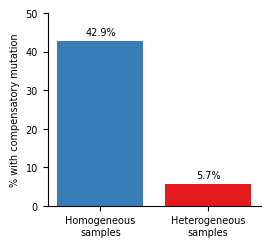

In [88]:
major_samples = samples[(~samples.HAS_MINOR_RAV) & (samples.HAS_MAJOR_RAV)]
minor_samples = samples[(samples.HAS_MINOR_RAV) & (~samples.HAS_MAJOR_RAV)]

major_prop_CM = (major_samples.HAS_COMPENSATORY_MUTATION & major_samples.MAX_CM_FRS>0.05).sum()/len(major_samples)
minor_prop_CM = (minor_samples.HAS_COMPENSATORY_MUTATION & minor_samples.MAX_CM_FRS>0.05).sum()/len(minor_samples)

plot_compensation_barplot(major_prop_CM, minor_prop_CM, save_name='bar-compensatory-frs', save_figure=True)

In [89]:
minor_samples_with_CM = minor_samples[minor_samples.HAS_COMPENSATORY_MUTATION & (minor_samples.MAX_CM_FRS<0.9)]
print(f"There are {len(minor_samples_with_CM)} minor RAV samples with a minor compensatory mutation")

There are 13 minor RAV samples with a minor compensatory mutation


If we are to look at the correlation between the FRS for the RAVs and CMs, we need to exclude ant samples with multiple mutations as these are likely to be more complex mixtures.

In [90]:
pd.crosstab(minor_samples_with_CM.N_RAV, minor_samples_with_CM.N_CM)

N_CM,1.0
N_RAV,
1.0,10
2.0,3


Pearson correlation coefficient: 0.9307
P-value: 9.2794e-05


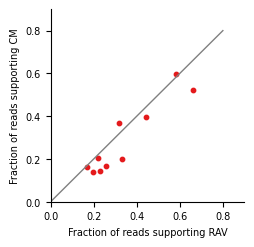

In [118]:
df = minor_samples_with_CM[(minor_samples_with_CM.N_RAV==1) & (minor_samples_with_CM.N_CM==1)]

import scipy.stats as stats

# Calculate Pearson correlation coefficient and p-value
corr_coeff, p_value = stats.pearsonr(df['MAX_RAV_FRS'], df['MAX_CM_FRS'])

# Print the results
print(f"Pearson correlation coefficient: {corr_coeff:.4f}")
print(f"P-value: {p_value:.4e}")

axis = df.plot('MAX_RAV_FRS', 'MAX_CM_FRS', kind='scatter', color='#e41a1c', s=10, figsize=(2.5,2.5))
figure = axis.get_figure()
axis.plot([0, 0.8], [0, 0.8], color='grey', lw=1)
axis.set_xlim(0,0.9)
axis.set_ylim(0,0.9)
axis.set_xticks(np.arange(0,0.9,0.2))
axis.set_yticks(np.arange(0,0.9,0.2))
axis.set_xlabel('Fraction of reads supporting RAV')
axis.set_ylabel('Fraction of reads supporting CM')

# Calculate the line of best fit
slope, intercept = np.polyfit(df['MAX_RAV_FRS'], df['MAX_CM_FRS'], 1)  # Linear regression
line_x = np.linspace(df['MAX_RAV_FRS'].min(), df['MAX_RAV_FRS'].max(), 100)
line_y = slope * line_x + intercept

# Plot the regression line
# plt.plot(line_x, line_y, color='blue', linewidth=1, label=f"y = {slope:.2f}x + {intercept:.2f}")

# remove unnecessary spines
axis.spines["top"].set_visible(False)
axis.spines["right"].set_visible(False)

figure.savefig('pdf/fig-cm-rav-fraction-reads.pdf', bbox_inches='tight', transparent=True)

## Genetic variation in heterogeneous samples with resistant subpopulations

Look at genetic variation to get insight into source of resistance (within-host evolution or secondary infection)

In [112]:
res_minor_uniqueids = samples[(samples['HAS_MINOR_RAV']) & (~samples['HAS_MAJOR_RAV'])].index
print(len(res_minor_uniqueids), 'samples show at least one RAV in a subpopulation and no RAV in over 90 % of the population')

438 samples show at least one RAV in a subpopulation and no RAV in over 90 % of the population


In [108]:
samples

,HAS_GENOME,HAS_DST,PHENOTYPE,HAS_RNAP_MUTATIONS,HAS_RESISTANT_MUTATION,N_RAV,HAS_MINOR_RAV,HAS_MAJOR_RAV,MAX_RAV_FRS,HAS_COMPENSATORY_MUTATION,N_CM,HAS_MINOR_CM,HAS_MAJOR_CM,MAX_CM_FRS,IS_RESISTANT
UNIQUEID,,,,,,,,,,,,,,,
site.01.subj.DR0682.lab.DR0682.iso.1,True,True,R,True,True,1.0,False,True,1.0,False,0.0,False,False,NaN,True
site.01.subj.DR0674.lab.DR0674.iso.1,True,False,NaN,True,True,1.0,False,True,1.0,False,0.0,False,False,NaN,False
site.01.subj.DR0134.lab.DR0134.iso.1,True,True,R,True,True,1.0,False,True,1.0,True,1.0,False,True,1.0,True
site.01.subj.DR0676.lab.DR0676.iso.1,True,False,NaN,True,True,1.0,False,True,1.0,True,1.0,False,True,1.0,False
site.01.subj.DR0690.lab.DR0690.iso.1,True,False,NaN,True,True,1.0,False,True,1.0,False,0.0,False,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.07.subj.C32A080B-63AC-4427-9257-073281798B4B.lab.C32A080B-63AC-4427-9257-073281798B4B.iso.1,True,True,S,True,False,0.0,False,False,NaN,False,0.0,False,False,NaN,False
site.07.subj.718655D6-1333-4F67-AABF-09C7E521D2B4.lab.718655D6-1333-4F67-AABF-09C7E521D2B4.iso.1,True,False,NaN,True,True,1.0,False,True,1.0,False,0.0,False,False,NaN,False
site.07.subj.FD_127_4342.lab.14_0600247.iso.1,True,True,S,False,False,NaN,False,False,NaN,False,NaN,False,False,NaN,False


We need to reprocess these samples using the variant calling pipeline, since with our previous settings mutations with less than 90% read support were not called unless they are resistance mutations. We reprocessed the 438 samples and load the data from the new files, starting with the `effects` table.

In [121]:
effects = pd.read_csv('data/reprocessed/effects.csv.gz')
effects = effects[(effects.drug=='RIF') & (effects.prediction=='R')]
summary_rif = effects[['uniqueid', 'mutation']].groupby('uniqueid').count()
summary_rif.mutation.value_counts()

mutation
1    291
2    121
3     16
Name: count, dtype: int64

We see some samples with more than one RIV RAF at <90% FRS. We will only look at the samples which have exaclty one minor RIF RAV, otherwise we will not know if both of these mutations are in the same subpopulation

In [122]:
solo_rif = summary_rif[summary_rif.mutation==1]
solo_rif_effects = effects[effects.uniqueid.isin(solo_rif.index)]
solo_rif_effects.set_index(['uniqueid','mutation'], inplace=True)
solo_rif_effects.index[:3]

MultiIndex([(                   'site.00.subj.1473471.lab.H140800280.iso.1.v0.12.4.per_sample', ...),
            (                         'site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.per_sample', ...),
            ('site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1.v0.12.4.per_sample', ...)],
           names=['uniqueid', 'mutation'])

Now we join the `mutations` table to the `effects` table, to obtain all mutations called in the 291 samples with one RIF RAV at <90% FRS. We ignore mutations that are RIF mutations themselves.

In [126]:
mutations = pd.read_csv('data/reprocessed/mutations.csv.gz') 
mutations.set_index(['uniqueid','mutation'], inplace=True)

solo_rif_mutations = mutations[mutations.index.isin(solo_rif_effects.index)]
solo_rif_mutations.reset_index(inplace=True)
solo_rif_mutations.set_index(['uniqueid','gene','gene_position'], inplace=True)
solo_rif_mutations

mutations.reset_index(inplace=True)
solo_mutations = mutations[mutations.uniqueid.isin(solo_rif.index)]
solo_mutations.set_index(['uniqueid','gene','gene_position'],inplace=True)

# don't forget to ignore the solo rif mutations themselves
solo_other_mutations = solo_mutations[~solo_mutations.index.isin(solo_rif_mutations.index)]
solo_other_mutations

mutation  \
uniqueid                                           gene   gene_position              
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE1     485.0             L485L   
                                                   PE14    106.0             A106A   
                                                   PE16    96.0               A96A   
                                                   PE2     298.0             I298T   
                                                   PE23    282.0             S282R   
...                                                                            ...   
site.35.subj.88.lab.IE12.iso.1.v0.12.4.per_sample  vapC31  31.0            L31L:28   
                                                           33.0            A33A:27   
                                                   vapC47  46.0               S46L   
                                                   whiB6  -75.0          -75_del_g   
                                                   yrbE2A  111.0             A111A   

                                                                         ref  \
uniqueid                                           gene   gene_position        
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE1     485.0         ctg   
                                                   PE14    106.0         gca   
                                                   PE16    96.0          gcg   
                                                   PE2     298.0         atc   
                                                   PE23    282.0         agt   
...                                                                      ...   
site.35.subj.88.lab.IE12.iso.1.v0.12.4.per_sample  vapC31  31.0          ctc   
                                                           33.0          gct   
                                                   vapC47  46.0          tcg   
                                                   whiB6  -75.0          NaN   
                                                   yrbE2A  111.0         gcc   

                                                                         alt  \
uniqueid                                           gene   gene_position        
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE1     485.0         ttg   
                                                   PE14    106.0         gcc   
                                                   PE16    96.0          gct   
                                                   PE2     298.0         acc   
                                                   PE23    282.0         agg   
...                                                                      ...   
site.35.subj.88.lab.IE12.iso.1.v0.12.4.per_sample  vapC31  31.0          ctt   
                                                           33.0          gcc   
                                                   vapC47  46.0          ttg   
                                                   whiB6  -75.0          NaN   
                                                   yrbE2A  111.0         gcg   

                                                                         nucleotide_number  \
uniqueid                                           gene   gene_position                      
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE1     485.0                       NaN   
                                                   PE14    106.0                       NaN   
                                                   PE16    96.0                        NaN   
                                                   PE2     298.0                       NaN   
                                                   PE23    282.0                       NaN   
...                                                                                    ...   
site.35.subj.88.lab.IE12.iso.1.v0.12.4.per_sample  vapC31  31.0                        NaN   
                           

Now we load the `variants`, which contains the FRS for each variant

In [130]:
variants = pd.read_pickle('data/reprocessed/variants.pkl.gz', compression='infer')
variants.reset_index(inplace=True)

def find_minors(row):
    if ':' in row.variant:
        read_fraction = float(row.variant.split(':')[1])
        return pd.Series([True, read_fraction])
    else:
        return pd.Series([False,1])
    
variants[['is_minor', 'read_fraction']] = variants.apply(find_minors, axis=1)

def find_nulls(row):
    if row.variant[-1] in ['x','X']:
        return True
    else:
        return False

variants['is_null'] = variants.apply(find_nulls, axis=1)


def get_DP_FRS(row):
    a = (json.loads(row['vcf_evidence']))
    if a['DP'] is None:
        depth = None
    else:
        depth = int(a['DP'])
    if a['COV'] is None:
        coverage = None
    else:
        coverage = sum(a['COV'])

    if a['FRS'] == '.':
        frs = None
    else:
        frs = float(a['FRS'])
    
    return pd.Series([depth, frs, coverage])

variants[['DP', 'FRS', 'COV']] = variants.apply(get_DP_FRS, axis=1)

def find_true_frs(row):
    a = (json.loads(row['vcf_evidence']))
    allele = row.vcf_idx
    if allele>=0:
        rd = a['COV'][int(allele)] / sum(a['COV'])
    else:
        rd = None
    return rd

variants['true_frs'] = variants.apply(find_true_frs, axis=1)

variants.set_index(['uniqueid','gene','gene_position'],inplace=True)
variants[:3]

variant  \
uniqueid                                           gene gene_position            
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0          1977a>g   
                                                   recF  56.0          3446c>t   
                                                         245.0         4013t>c   

                                                                       codon_idx  \
uniqueid                                           gene gene_position              
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                NaN   
                                                   recF  56.0                1.0   
                                                         245.0               1.0   

                                                                       nucleotide_index  \
uniqueid                                           gene gene_position                     
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                      1977   
                                                   recF  56.0                      3446   
                                                         245.0                     4013   

                                                                       indel_length  \
uniqueid                                           gene gene_position                 
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                     0   
                                                   recF  56.0                     0   
                                                         245.0                    0   

                                                                      indel_nucleotides  \
uniqueid                                           gene gene_position                     
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                       NaN   
                                                   recF  56.0                       NaN   
                                                         245.0                      NaN   

                                                                                                            vcf_evidence  \
uniqueid                                           gene gene_position                                                      
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0          {"DP": 14, "GT_CONF": 97.1, "COV": [0, 14], "A...   
                                                   recF  56.0          {"COV": [0, 24], "COV_TOTAL": 24, "GT": [1, 1]...   
                                                         245.0         {"COV": [0, 16], "ALLELE_DP": [0, 16], "COV_TO...   

                                                                       vcf_idx  \
uniqueid                                           gene gene_position            
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0              1.0   
                                                   recF  56.0              1.0   
                                                         245.0             1.0   

                                                                       is_minor  \
uniqueid                                           gene gene_position             
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0             False   
                                                   recF  56.0             False   
                                                         245.0            False   

                                                                       read_fraction  \
uniqueid                                           gene gene_position                  
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                    1.0   
                                                   recF  56.0                    1.0   
                                                         245.0                   1.0   

  

Now we can join the table of solo RIF RAVs and the table with other mutations to `variants` to find out the FRS for each mutation

In [134]:
solo_rif_variants = solo_rif_mutations[['mutation']].join(variants, how='inner')
solo_rif_variants.reset_index(inplace=True)
solo_rif_variants.set_index(['uniqueid'], inplace=True)

#here we need to ignore any null calls, any non minor calls and we set a threshold based on `COV` 
solo_other_variants = solo_other_mutations[['mutation']].join(variants, how='inner')
solo_other_variants = solo_other_variants[(~solo_other_variants.is_null) & (solo_other_variants.is_minor) & (solo_other_variants.COV>5)]
solo_other_variants[:3]

mutation  \
uniqueid                                           gene      gene_position             
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0           R225G:6   
                                                             227.0           R227G:6   
                                                             248.0          T248T:15   

                                                                                 variant  \
uniqueid                                           gene      gene_position                 
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0           839123a>g:6   
                                                             227.0           839129c>g:6   
                                                             248.0          839194a>g:15   

                                                                            codon_idx  \
uniqueid                                           gene      gene_position              
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0                0.0   
                                                             227.0                0.0   
                                                             248.0                2.0   

                                                                            nucleotide_index  \
uniqueid                                           gene      gene_position                     
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0                    839123   
                                                             227.0                    839129   
                                                             248.0                    839194   

                                                                            indel_length  \
uniqueid                                           gene      gene_position                 
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0                     0   
                                                             227.0                     0   
                                                             248.0                     0   

                                                                           indel_nucleotides  \
uniqueid                                           gene      gene_position                     
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0                       NaN   
                                                             227.0                       NaN   
                                                             248.0                       NaN   

                                                                                                                 vcf_evidence  \
uniqueid                                           gene      gene_position                                                      
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0          {"GT_CONF_PERCENTILE": 0.02, "COV": [0, 6], "D...   
                                                             227.0          {"GT": [1, 1], "FRS": 1.0, "GT_CONF_PERCENTILE...   
                                                             248.0          {"GT_CONF": 115.47, "DP": 15, "ALLELE_DP": [0,...   

                                                                            vcf_idx  \
uniqueid                                           gene      gene_position            
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0              1.0   
                                                             227.0              1.0   
                                                             248.0              1.0   

                                                                            is_minor  \
uniqueid                                           gene      gene_position             
site.00.subj.1473471.lab.H140800280.iso.1.v0.12

We now count the number of minor mutations in each of the 291 samples with one RIF RAV <90% FRS

In [135]:
solo_other_variants.reset_index(inplace=True)
solo_other_variants_count = solo_other_variants[['uniqueid','gene_position']].groupby('uniqueid').count()
solo_other_variants_count.rename(columns={'gene_position':'minor_count'}, inplace=True)
solo_other_variants_count

,minor_count
uniqueid,
site.00.subj.1473471.lab.H140800280.iso.1.v0.12.4.per_sample,140
site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.per_sample,97
site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1.v0.12.4.per_sample,78
site.00.subj.NETHERLANDS_NLA009702465.lab.NLA009702465.iso.1.v0.12.4.per_sample,117
site.01.subj.DR0182.lab.DR0182.iso.1.v0.12.4.per_sample,1214
...,...
site.28.subj.1007.lab.R12077.iso.2.v0.12.4.per_sample,1514
site.28.subj.1371.lab.R12076.iso.1.v0.12.4.per_sample,1422
site.28.subj.2133.lab.R28017.iso.1.v0.12.4.per_sample,1384


Now we join the table containing the count of minor mutations per sample to the table reporting the RIF mutations in the 291 samples

In [177]:
df = solo_rif_variants.join(solo_other_variants_count)
df

,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,vcf_evidence,vcf_idx,is_minor,read_fraction,is_null,DP,FRS,COV,true_frs,minor_count
uniqueid,,,,,,,,,,,,,,,,,,
site.00.subj.1473471.lab.H140800280.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,"{""ALLELE_DP"": [42, 75], ""FRS"": 0.641, ""GT_CONF...",1.0,True,75.0,False,75.0,0.6410,117.0,0.641026,140
site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.per_sample,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,"{""DP"": 32, ""GT_CONF"": 124.78, ""GT"": [0, 0], ""A...",1.0,True,12.0,False,32.0,0.7273,44.0,0.272727,97
site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1.v0.12.4.per_sample,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,"{""GT"": [0, 0], ""FRS"": 0.871, ""GT_CONF"": 430.96...",1.0,True,12.0,False,81.0,0.8710,93.0,0.129032,78
site.00.subj.NETHERLANDS_NLA009702465.lab.NLA009702465.iso.1.v0.12.4.per_sample,rpoB,445.0,H445D:11,761139c>g:11,0.0,761139,0,NaN,"{""COV"": [23, 11], ""DP"": 23, ""GT"": [0, 0], ""GT_...",1.0,True,11.0,False,23.0,0.6765,34.0,0.323529,117
site.01.subj.DR0182.lab.DR0182.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:10,761155c>t:10,1.0,761155,0,NaN,"{""GT"": [0, 0], ""COV"": [69, 10], ""FRS"": 0.8734,...",1.0,True,10.0,False,69.0,0.8734,79.0,0.126582,1214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.28.subj.1007.lab.R12077.iso.2.v0.12.4.per_sample,rpoB,450.0,S450L:82,761155c>t:82,1.0,761155,0,NaN,"{""COV"": [57, 82], ""GT"": [1, 1], ""ALLELE_DP"": [...",1.0,True,82.0,False,82.0,0.5899,139.0,0.589928,1514
site.28.subj.1371.lab.R12076.iso.1.v0.12.4.per_sample,rpoB,435.0,D435Y:28,761109g>t:28,0.0,761109,0,NaN,"{""FRS"": 0.7971, ""GT_CONF_PERCENTILE"": 12.66, ""...",1.0,True,28.0,False,110.0,0.7971,138.0,0.202899,1422
site.28.subj.2133.lab.R28017.iso.1.v0.12.4.per_sample,rpoB,435.0,D435Y:5,761109g>t:5,0.0,761109,0,NaN,"{""DP"": 32, ""GT_CONF"": 170.23, ""GT"": [0, 0], ""C...",1.0,True,5.0,False,32.0,0.8649,37.0,0.135135,1384


We now plot the distribution of minor mutation counts for all 291 samples with one RIF RAV <90% FRS

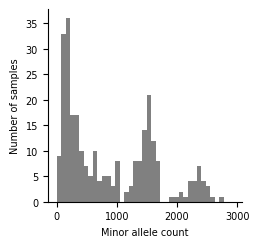

In [178]:
#plot the ditribution of minor alleles in the solo rif samples
fig, ax = plt.subplots(figsize=(2.5,2.5))
df.minor_count.plot(kind='hist', bins=range(0,3000,75), color='grey', ax=ax)
ax.set_xlabel('Minor allele count')
ax.set_ylabel('Number of samples')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig('pdf/bar-minor-allele-counts.pdf', bbox_inches='tight', transparent=True)

We can plot the assigned number of (sub)lineages from our pipeline on the distribution. For this, we need to get the ENA accession number of the samples in this plot from the cryptic ENA lookup table. We can then use this to pull the relevant samples from ENA and process them using Mykrobe. (change this to EIT pathogena?)

In [179]:
def correct_uid(row):
    return row.uniqueid.split('.v0.12.4.per_sample')[0]

df.reset_index(inplace=True)
df['UNIQUEID'] = df.apply(correct_uid, axis=1)
df.set_index('UNIQUEID', inplace=True)
df[:3]

,uniqueid,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,vcf_evidence,vcf_idx,is_minor,read_fraction,is_null,DP,FRS,COV,true_frs,minor_count
UNIQUEID,,,,,,,,,,,,,,,,,,,
site.00.subj.1473471.lab.H140800280.iso.1,site.00.subj.1473471.lab.H140800280.iso.1.v0.1...,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,"{""ALLELE_DP"": [42, 75], ""FRS"": 0.641, ""GT_CONF...",1.0,True,75.0,False,75.0,0.6410,117.0,0.641026,140
site.00.subj.ES_FE21.lab.FE21.iso.1,site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.pe...,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,"{""DP"": 32, ""GT_CONF"": 124.78, ""GT"": [0, 0], ""A...",1.0,True,12.0,False,32.0,0.7273,44.0,0.272727,97
site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,"{""GT"": [0, 0], ""FRS"": 0.871, ""GT_CONF"": 430.96...",1.0,True,12.0,False,81.0,0.8710,93.0,0.129032,78


In [180]:
ENA_LOOKUP = pd.read_csv('data/Mykrobe_EIT_pathogena/ENA_LOOKUP.csv.gz')
ENA_LOOKUP.set_index('UNIQUEID', inplace=True)
ENA_LOOKUP[:3]

df2 = df.join(ENA_LOOKUP[['run_accession', 'fastq_ftp']], how='left')
df2 = df2[~df2.index.duplicated(keep=False)]
df2.to_csv('data/Mykrobe_EIT_pathogena/minor_rif_variants.csv')

In [181]:
df = pd.read_csv('data/Mykrobe_EIT_pathogena/minor_rif_variants.csv')
df.set_index('run_accession', inplace=True)
df[:3]

,UNIQUEID,uniqueid,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,...,vcf_idx,is_minor,read_fraction,is_null,DP,FRS,COV,true_frs,minor_count,fastq_ftp
run_accession,,,,,,,,,,,,,,,,,,,,,
ERR2516785,site.00.subj.1473471.lab.H140800280.iso.1,site.00.subj.1473471.lab.H140800280.iso.1.v0.1...,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,...,1.0,True,75.0,False,75.0,0.6410,117.0,0.641026,140,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/005/ERR251...
ERR2516111,site.00.subj.ES_FE21.lab.FE21.iso.1,site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.pe...,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,...,1.0,True,12.0,False,32.0,0.7273,44.0,0.272727,97,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/001/ERR251...
ERR2516629,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,...,1.0,True,12.0,False,81.0,0.8710,93.0,0.129032,78,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/009/ERR251...


The processed data from Mykrobe was downloaded and can be loaded into the notebook

In [182]:
mykrobe = pd.read_csv('data/Mykrobe_EIT_pathogena/mykrobe_results.csv')
mykrobe.set_index('ena_run_accession', inplace=True)
mykrobe[:3]

,lineage_count,lineage_1,lineage_2,lineage_3,lineage_4,mixture_type
ena_run_accession,,,,,,
ERR4800035,1,lineage3,NaN,NaN,NaN,single
ERR4798238,2,lineage3,lineage4.3.3,NaN,NaN,major
ERR4813926,1,lineage4.1.2.1,NaN,NaN,NaN,single


We join the Mykrobe results to our data table containing the number of minor alleles per sample

In [183]:
df = df.join(mykrobe)
df

,UNIQUEID,uniqueid,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,...,COV,true_frs,minor_count,fastq_ftp,lineage_count,lineage_1,lineage_2,lineage_3,lineage_4,mixture_type
run_accession,,,,,,,,,,,,,,,,,,,,,
ERR2516785,site.00.subj.1473471.lab.H140800280.iso.1,site.00.subj.1473471.lab.H140800280.iso.1.v0.1...,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,...,117.0,0.641026,140,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/005/ERR251...,1.0,lineage2.2,NaN,NaN,NaN,single
ERR2516111,site.00.subj.ES_FE21.lab.FE21.iso.1,site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.pe...,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,...,44.0,0.272727,97,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/001/ERR251...,1.0,lineage4.1.2.1,NaN,NaN,NaN,single
ERR2516629,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,...,93.0,0.129032,78,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/009/ERR251...,1.0,lineage4.4.1.1,NaN,NaN,NaN,single
ERR2516477,site.00.subj.NETHERLANDS_NLA009702465.lab.NLA0...,site.00.subj.NETHERLANDS_NLA009702465.lab.NLA0...,rpoB,445.0,H445D:11,761139c>g:11,0.0,761139,0,NaN,...,34.0,0.323529,117,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/007/ERR251...,1.0,lineage4.1.2.1,NaN,NaN,NaN,single
ERR13259958,site.01.subj.DR0182.lab.DR0182.iso.1,site.01.subj.DR0182.lab.DR0182.iso.1.v0.12.4.p...,rpoB,450.0,S450L:10,761155c>t:10,1.0,761155,0,NaN,...,79.0,0.126582,1214,ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/058/ERR132...,2.0,lineage2.2.9,lineage4.10,NaN,NaN,major
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR9121135,site.26.subj.16.lab.G102.iso.1,site.26.subj.16.lab.G102.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:16,761155c>t:16,1.0,761155,0,NaN,...,65.0,0.246154,254,ftp.sra.ebi.ac.uk/vol1/fastq/ERR912/005/ERR912...,1.0,lineage2.2.10,NaN,NaN,NaN,single
ERR13285190,site.28.subj.1007.lab.R12077.iso.2,site.28.subj.1007.lab.R12077.iso.2.v0.12.4.per...,rpoB,450.0,S450L:82,761155c>t:82,1.0,761155,0,NaN,...,139.0,0.589928,1514,ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/090/ERR132...,2.0,lineage2.2.1,lineage3,NaN,NaN,major
ERR9119906,site.28.subj.1371.lab.R12076.iso.1,site.28.subj.1371.lab.R12076.iso.1.v0.12.4.per...,rpoB,435.0,D435Y:28,761109g>t:28,0.0,761109,0,NaN,...,138.0,0.202899,1422,ftp.sra.ebi.ac.uk/vol1/fastq/ERR911/006/ERR911...,2.0,lineage2.2,lineage4.10,NaN,NaN,major


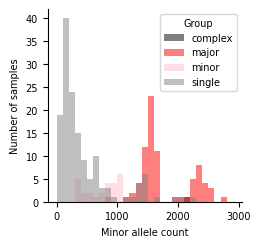

In [191]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(2.5, 2.5))  # Adjust the size as needed

# Define colors for each group
colors = ['black', 'red', 'pink', 'grey']

# Group the data by the column with strings
groups = df.groupby('mixture_type')

# Loop through each group and plot its histogram
for (label, group), color in zip(groups, colors):
    group['minor_count'].plot(
        kind='hist',
        bins=range(0, 3000, 100),  # Adjust bin size if necessary
        color=color,
        alpha=0.5,  # Make bars semi-transparent for overlapping
        label=label,
        ax=ax
    )

# Add labels, legend, and customize appearance
ax.set_xlabel('Minor allele count')
ax.set_ylabel('Number of samples')
ax.legend(title='Group', loc='upper right')  # Adjust legend location
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show the plot
plt.show()

fig.savefig('pdf/bar-lineage-minor-allele-counts.pdf', bbox_inches='tight', transparent=True)